# Business Insight - Customer Segments

This notebook aims at segmenting customers into groups based on their product use

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import seaborn as sns

## Import data

In [2]:
df = pd.read_csv('Active_Devices_per_user_per_day.csv',index_col=0, parse_dates=True)

## Heatmap

The heatmap displays all time series of product use across all customers

In [4]:
# mask for the heatmap [exclude points where use=0]
mask = (df==0)

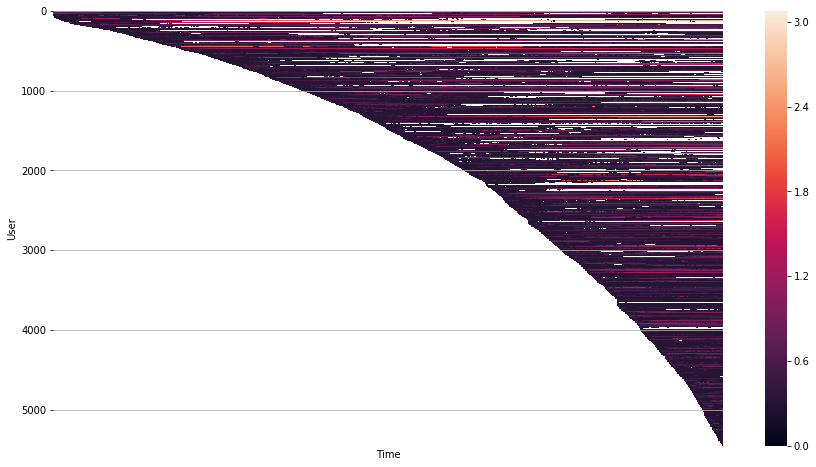

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(np.log10(df.T+1), xticklabels = False, yticklabels=False,mask = mask.T);
ytks = np.arange(0,df.shape[1],1000)
ytkslabel =[ str(num) for num in ytks]
plt.yticks(ytks);
ax.set_yticklabels(ytkslabel)
plt.grid();
plt.xlabel('Time');
plt.ylabel('User');

The plot is to be read horizontally. Each series is represented in colours and shown in log10 scale. The many white areas indicate that a lot of uses do not actually use the product.

### Active users

Users with at least one device in use:

In [6]:
active_users = np.sum(df>0, axis=1)

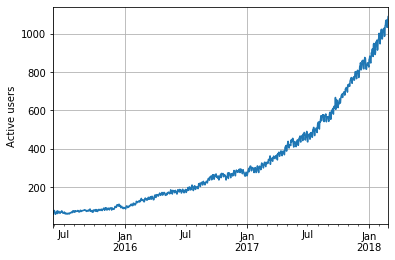

In [7]:
active_users.plot();
plt.grid();
plt.ylabel('Active users');

The number of active users has been growing over time, with a similar trend identified for the connected devices over time (see [07_Future_Projection](07_Future_Projection.ipynb))

## User analytics

Extract main features of customer use:
- first use date
- last use date
- days since first use
- number of active days, both in absolute and relatively to the number of days since first use
- number of inactive days since last use, both absolute and relative
- mean of the device count time derivative
- max number of devices used at any time

In [11]:
first_use_date=[]
last_use_date = []
days_since_first_use=[]
active_days_abs = []
active_days_rel = []
inactive_days_since_last_use = []
mean_der = [] # mean of numerical derivative
#
for user, col in tqdm_notebook(df.iteritems(), total=df.shape[1]):
    first_use_date.append(col[col>0].iloc[0:1].index[0])
    last_use_date.append( col[col>0].iloc[-1:].index[0])
    days_since_first_use.append(int((datetime(2018,3,1)- first_use_date[-1])/timedelta(days=1)))
    # series from first use
    sub = col[col.index>=first_use_date[-1]]
    active_days_abs.append( sum(sub>0) )
    active_days_rel.append( active_days_abs[-1]/days_since_first_use[-1])
    #
    mean_der.append(np.mean(col.diff()))
    inactive_days_since_last_use.append( int((datetime(2018,2,28)- last_use_date[-1])/timedelta(days=1) ))


In [13]:
user_analytics = pd.DataFrame({'first_use_date': first_use_date,
                              'last_use_date': last_use_date,
                              'days_since_first_use': days_since_first_use,
                              'active_days_abs': active_days_abs,
                              'active_days_rel': active_days_rel,
                              'inactive_days_since_last_use': inactive_days_since_last_use,
                              'mean_der': mean_der},
                             index= df.columns)

In [14]:
user_analytics['inactive_days_since_last_use_rel'] = \
    user_analytics.inactive_days_since_last_use/user_analytics.days_since_first_use

In [15]:
user_analytics['max_devices']=df.max().astype(int)

In [16]:
user_analytics.head()

first_use_date last_use_date  days_since_first_use  active_days_abs  \
1     2015-05-31    2018-02-28                  1005             1005   
2     2015-05-31    2015-06-05                  1005                6   
3     2015-05-31    2015-09-20                  1005                4   
4     2015-05-31    2018-02-28                  1005             1005   
5     2015-05-31    2017-10-15                  1005               30   

   active_days_rel  inactive_days_since_last_use  mean_der  \
1         1.000000                             0 -0.126494   
2         0.005970                           999 -0.000996   
3         0.003980                           892 -0.000996   
4         1.000000                             0 -0.032869   
5         0.029851                           136 -0.005976   

   inactive_days_since_last_use_rel  max_devices  
1                          0.000000          131  
2                          0.994030            1  
3                          0.887562            1  
4                          0.000000           86  
5                          0.135323            6

Save csv file

In [17]:
user_analytics.to_csv('User_Analytics.csv')

## Analysis

Categories:
- 1) One-time users
- 2) Active users
- 3) Big whales
- 4) Rapidly growing users
- 5) Previously active users

### 1) One-time users

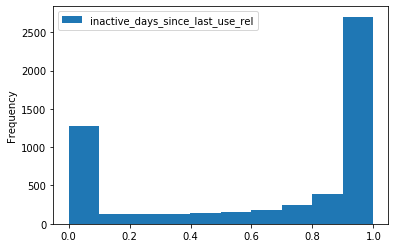

In [19]:
user_analytics.plot.hist(y='inactive_days_since_last_use_rel');

There is a large number of users who used the product once or twice. Probably these users tested the product but did not proceed with the purchase/use. Although they are not active customers, it would make sense ask some of them why they did not eventually buy the product and what it would take them to do so.

To identify these users simply filter on the parameter 'inactive_days_since_last_use_rel'

In [29]:
one_time_users =\
    user_analytics.index[user_analytics.inactive_days_since_last_use_rel>0.9]

In [30]:
len(one_time_users)

2690

Example of one-time user:

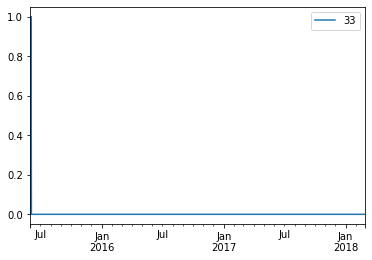

In [31]:
df.plot.line(y=one_time_users[12]);

### 2) Active users

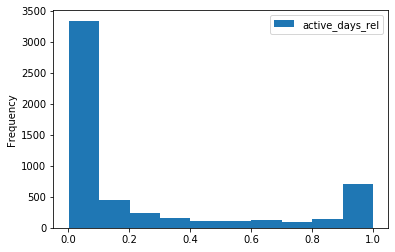

In [32]:
user_analytics.plot.hist(y='active_days_rel');

Most users have used the product only for few days, but there exists a good community of users that have been actively using the product. It is necessary to keep them engaged (newsletter, events and so on) to sustain the business. Those with low active days should be pushed to increase their use.

In [35]:
active_users = user_analytics.index[user_analytics.active_days_rel>0.5]

In [36]:
len(active_users)

1173

### 3) Big whales

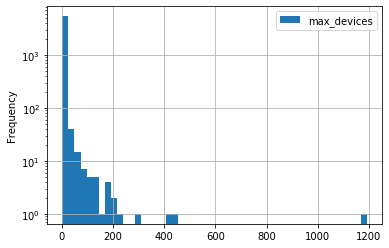

In [39]:
user_analytics.plot.hist(y='max_devices',bins=50);
plt.yscale('log');
plt.grid();

Most users have only a few devices, however a small number of them have a lot of devices. These so-called 'big whales' are important customers, treat them well!

In [40]:
big_whales = user_analytics.index[user_analytics.max_devices>150]

In [41]:
len(big_whales)

12

Customer with most devices at any time:

In [45]:
biggest_whale = user_analytics.max_devices.idxmax()

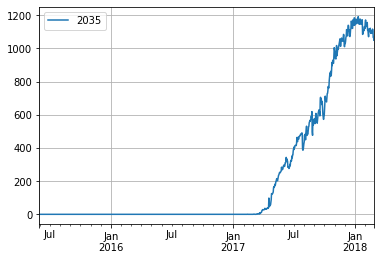

In [47]:
df.plot(y=biggest_whale);
plt.grid();

### 4) Rapidly growing customers

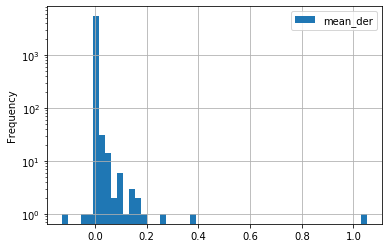

In [49]:
user_analytics.plot.hist(y='mean_der',bins=50);
plt.yscale('log');
plt.grid();

This last histogram represents the distribution of the time average of the device count derivative. Positive values mean consistent use growth. These customers are a good opportunity for upselling.

In [54]:
mean_der_sigma = np.std(user_analytics.mean_der)
growing_customers = user_analytics.index[user_analytics.mean_der > 3* mean_der_sigma]

In [55]:
len(growing_customers)

22

Example:

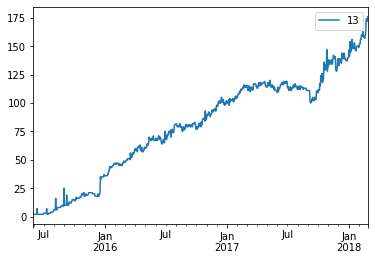

In [53]:
df.plot.line(y=growing_customers[0]);

Likewise, we can inspect those decreasing their use

In [56]:
desc_customers = user_analytics.index[user_analytics.mean_der < -3* mean_der_sigma]

In [57]:
len(desc_customers)

1

There is only one such customer, it would make sense trying to understand what is happening

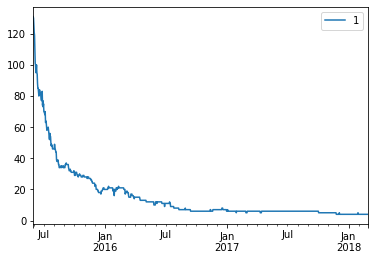

In [59]:
df.plot.line(y=desc_customers);

### 5) Previously active customers

These are the customers who used to use the product but haven't used it for a while. It makes sense trying to re-engage them if they haven't left the product yet.

In [60]:
previously_active_users = user_analytics.index[(user_analytics.active_days_rel>0.6) &
    (user_analytics.inactive_days_since_last_use>60)]
len(previously_active_users)

34

Example:

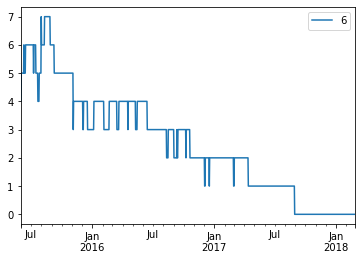

In [61]:
df.plot.line(y=previously_active_users[0]);